# DeepTendies Example Notebook
## Hyper parameter optimization for AAPL data

* Author: Mike Lasby
* Date: 2021-04-11
* Last Updated: 2021-04-11
* Reviewed by: N/A 

In [ ]:
%%bash
pip install -r https://raw.githubusercontent.com/deeptendies/deeptendies/master/requirements.txt && pip install git+https://github.com/deeptendies/deeptendies


  Cloning https://github.com/deeptendies/deeptendies to /tmp/pip-req-build-bn9fk4d6
  Created wheel for deeptendies: filename=deeptendies-0.0.1.dev0-cp37-none-any.whl size=19341 sha256=a39805639003ce2bf16d4eeccd0cfe5a2954b264153be72f92d934ee876dee89
  Stored in directory: /tmp/pip-ephem-wheel-cache-2bgc4hqd/wheels/7b/aa/b9/42f9bb23e2644e4f8ab23852dd55e3b0a1bcdc518dd13f1631
Successfully built deeptendies


  Running command git clone -q https://github.com/deeptendies/deeptendies /tmp/pip-req-build-bn9fk4d6


# Data ingestion from API

In [ ]:
from deeptendies.stock_data import StockData
from deeptendies.trainer import Trainer
from deeptendies.model_metrics import ModelMetrics
# NOTE: Update stock name !
STOCK_NAME = 'AAPL'
closing_data = StockData(STOCK_NAME, days=7300, api_key="c1h8m1n48v6t9ghtpkh0")

Note: the following two cells is fo us to have the same appl data for generating the final report. **If you are using your own ticker, do not run the next 2 cells. just use the cell above**

In [ ]:
# TODO: final report only cell #1
# run this to connect gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Ingestion from static data store
This data is used for hyper parameter tuning or other experimentation using a common dataset

In [ ]:
# # TODO: final report only cell #2
# # run this to load team_data
# import pandas as pd
# # TODO: Please use this for getting final data to generate the final report
# aapl_finrep_data = "/content/drive/MyDrive/enel645-team-drive/Final-Project/AAPL_7300.csv" # stock.df.to_csv(aapl_finrep_data)
# aapl_data_df = pd.read_csv(aapl_finrep_data, index_col=0)
# aapl_data_df['t'] = pd.to_datetime(aapl_data_df['t'])
# closing_data.df = aapl_data_df

#Targets: 
  * Tomorrow's closing price 
  * n<sup>th</sup> day high/low (eg., high price in next 5 days, low price in next 5 days)

In [ ]:
from copy import deepcopy 
# Prepare 3 df's one for each target (5 day high, 5 day low, & tomorrow's closing price )
five_day_low_data = deepcopy(closing_data)
five_day_high_data = deepcopy(closing_data)
dfs = [closing_data, five_day_high_data, five_day_low_data]

# Data Exploration

In [ ]:
closing_data.df

,c,h,l,o,s,t,v,wma
0,0.447139,0.45768,0.439289,0.445180,ok,2001-04-20 00:00:00,12382512,0.000000
1,0.433039,0.44643,0.428570,0.434639,ok,2001-04-23 00:00:00,9670209,0.000000
2,0.429111,0.44643,0.419820,0.434461,ok,2001-04-24 00:00:00,6734306,0.433425
3,0.441430,0.44393,0.420889,0.432320,ok,2001-04-25 00:00:00,5906905,0.435925
4,0.440889,0.46607,0.440711,0.449461,ok,2001-04-26 00:00:00,14280514,0.439107
...,...,...,...,...,...,...,...,...
5022,130.360000,130.39000,128.520000,128.950000,ok,2021-04-08 00:00:00,88844591,128.848333
5023,132.995000,133.04000,129.470000,129.800000,ok,2021-04-09 00:00:00,106686703,131.267500
5024,131.240000,132.85000,130.630000,132.520000,ok,2021-04-12 00:00:00,91419983,131.678333
5025,134.430000,134.66000,131.930000,132.440000,ok,2021-04-13 00:00:00,91266500,133.127500


In [ ]:
for df in dfs: 
  df.engineer_features() #engineer all features
closing_data.df

,c,h,l,o,s,t,v,wma,day_of_week,day_of_year,is_quarter_end,100wma,100mvwap,50wma,50mvwap,20wma,20mvwap,next_1_high,next_1_low,next_3_high,next_3_low,next_5_high,next_5_low,next_7_high,next_7_low,last_1_high,last_1_low,last_3_high,last_3_low,last_5_high,last_5_low,last_7_high,last_7_low
0,0.447139,0.45768,0.439289,0.445180,ok,2001-04-20 00:00:00,12382512,0.000000,4,110,False,NaN,0.448036,NaN,0.448036,NaN,0.448036,0.446430,0.428570,0.446430,0.419820,0.469461,0.419820,0.484289,0.419820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.433039,0.44643,0.428570,0.434639,ok,2001-04-23 00:00:00,9670209,0.000000,0,113,False,NaN,0.442764,NaN,0.442764,NaN,0.442764,0.446430,0.419820,0.466070,0.419820,0.484289,0.419820,0.484289,0.419820,0.45768,0.439289,NaN,NaN,NaN,NaN,NaN,NaN
2,0.429111,0.44643,0.419820,0.434461,ok,2001-04-24 00:00:00,6734306,0.433425,1,114,False,NaN,0.440196,NaN,0.440196,NaN,0.440196,0.443930,0.420889,0.469461,0.420889,0.484289,0.420889,0.484289,0.420889,0.44643,0.428570,NaN,NaN,NaN,NaN,NaN,NaN
3,0.441430,0.44393,0.420889,0.432320,ok,2001-04-25 00:00:00,5906905,0.435925,2,115,False,NaN,0.439382,NaN,0.439382,NaN,0.439382,0.466070,0.440711,0.484289,0.440711,0.484289,0.440711,0.484289,0.427861,0.44643,0.419820,NaN,NaN,NaN,NaN,NaN,NaN
4,0.440889,0.46607,0.440711,0.449461,ok,2001-04-26 00:00:00,14280514,0.439107,3,116,False,NaN,0.442252,NaN,0.442252,NaN,0.442252,0.469461,0.441961,0.484289,0.441961,0.484289,0.441611,0.484289,0.427861,0.44393,0.420889,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,130.360000,130.39000,128.520000,128.950000,ok,2021-04-08 00:00:00,88844591,128.848333,3,98,False,127.042429,126.726422,124.292294,126.358568,123.825571,122.824776,133.040000,129.470000,134.660000,129.470000,NaN,NaN,NaN,NaN,127.92000,125.140000,126.1601,121.15,123.5200,118.86,124.2400,118.92
5023,132.995000,133.04000,129.470000,129.800000,ok,2021-04-09 00:00:00,106686703,131.267500,4,99,False,127.165805,126.849174,124.530047,126.047962,124.765762,123.337585,132.850000,130.630000,135.000000,130.630000,NaN,NaN,NaN,NaN,130.39000,128.520000,127.1300,122.49,124.1800,118.86,124.2400,118.86
5024,131.240000,132.85000,130.630000,132.520000,ok,2021-04-12 00:00:00,91419983,131.678333,0,102,False,127.251699,126.951038,124.706086,125.804609,125.486262,123.837415,134.660000,131.930000,NaN,NaN,NaN,NaN,NaN,NaN,133.04000,129.470000,127.9200,123.07,126.1601,118.86,124.2400,118.86
5025,134.430000,134.66000,131.930000,132.440000,ok,2021-04-13 00:00:00,91266500,133.127500,1,103,False,127.398389,127.070471,125.011812,125.697898,126.461952,124.330824,135.000000,131.660000,NaN,NaN,NaN,NaN,NaN,NaN,132.85000,130.630000,130.3900,125.14,127.1300,118.86,124.1800,118.86


In [ ]:
# reorder columns! NOTE: REQUIRED ORDERING! columns in index [0:x] are not to be normalized. Column at index x is the target vector. Column idx > x will be normalized. 
closing_data.reorder_cols(['day_of_week',
                        'day_of_year',
                        'is_quarter_end',
                        'c', 'h', 'l', 'o', 's', 't', 'v', 'wma',
                        '100wma', '100mvwap', '50wma', '50mvwap', '20wma','20mvwap', 'next_1_high', 'next_1_low',
                        'next_3_high', 'next_3_low','next_5_high', 'next_5_low', 'next_7_high', 'next_7_low',
                        'last_1_high','last_1_low', 'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low','last_7_high', 'last_7_low'])

five_day_high_data.reorder_cols(['day_of_week',
                        'day_of_year',
                        'is_quarter_end',
                        'next_5_high', 'c', 'h', 'l', 'o', 's', 't', 'v', 'wma',
                        '100wma', '100mvwap', '50wma', '50mvwap', '20wma','20mvwap', 'next_1_high', 'next_1_low',
                        'next_3_high', 'next_3_low', 'next_5_low', 'next_7_high', 'next_7_low',
                        'last_1_high','last_1_low', 'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low','last_7_high', 'last_7_low'])

five_day_low_data.reorder_cols(['day_of_week',
                        'day_of_year',
                        'is_quarter_end', 'next_5_low', 
                        'c', 'h', 'l', 'o', 's', 't', 'v', 'wma',
                        '100wma', '100mvwap', '50wma', '50mvwap', '20wma','20mvwap', 'next_1_high', 'next_1_low',
                        'next_3_high', 'next_3_low','next_5_high', 'next_7_high', 'next_7_low',
                        'last_1_high','last_1_low', 'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low','last_7_high', 'last_7_low'])
closing_data.df

,day_of_week,day_of_year,is_quarter_end,c,h,l,o,s,t,v,wma,100wma,100mvwap,50wma,50mvwap,20wma,20mvwap,next_1_high,next_1_low,next_3_high,next_3_low,next_5_high,next_5_low,next_7_high,next_7_low,last_1_high,last_1_low,last_3_high,last_3_low,last_5_high,last_5_low,last_7_high,last_7_low
0,4,110,False,0.447139,0.45768,0.439289,0.445180,ok,2001-04-20 00:00:00,12382512,0.000000,NaN,0.448036,NaN,0.448036,NaN,0.448036,0.446430,0.428570,0.446430,0.419820,0.469461,0.419820,0.484289,0.419820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,113,False,0.433039,0.44643,0.428570,0.434639,ok,2001-04-23 00:00:00,9670209,0.000000,NaN,0.442764,NaN,0.442764,NaN,0.442764,0.446430,0.419820,0.466070,0.419820,0.484289,0.419820,0.484289,0.419820,0.45768,0.439289,NaN,NaN,NaN,NaN,NaN,NaN
2,1,114,False,0.429111,0.44643,0.419820,0.434461,ok,2001-04-24 00:00:00,6734306,0.433425,NaN,0.440196,NaN,0.440196,NaN,0.440196,0.443930,0.420889,0.469461,0.420889,0.484289,0.420889,0.484289,0.420889,0.44643,0.428570,NaN,NaN,NaN,NaN,NaN,NaN
3,2,115,False,0.441430,0.44393,0.420889,0.432320,ok,2001-04-25 00:00:00,5906905,0.435925,NaN,0.439382,NaN,0.439382,NaN,0.439382,0.466070,0.440711,0.484289,0.440711,0.484289,0.440711,0.484289,0.427861,0.44643,0.419820,NaN,NaN,NaN,NaN,NaN,NaN
4,3,116,False,0.440889,0.46607,0.440711,0.449461,ok,2001-04-26 00:00:00,14280514,0.439107,NaN,0.442252,NaN,0.442252,NaN,0.442252,0.469461,0.441961,0.484289,0.441961,0.484289,0.441611,0.484289,0.427861,0.44393,0.420889,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,3,98,False,130.360000,130.39000,128.520000,128.950000,ok,2021-04-08 00:00:00,88844591,128.848333,127.042429,126.726422,124.292294,126.358568,123.825571,122.824776,133.040000,129.470000,134.660000,129.470000,NaN,NaN,NaN,NaN,127.92000,125.140000,126.1601,121.15,123.5200,118.86,124.2400,118.92
5023,4,99,False,132.995000,133.04000,129.470000,129.800000,ok,2021-04-09 00:00:00,106686703,131.267500,127.165805,126.849174,124.530047,126.047962,124.765762,123.337585,132.850000,130.630000,135.000000,130.630000,NaN,NaN,NaN,NaN,130.39000,128.520000,127.1300,122.49,124.1800,118.86,124.2400,118.86
5024,0,102,False,131.240000,132.85000,130.630000,132.520000,ok,2021-04-12 00:00:00,91419983,131.678333,127.251699,126.951038,124.706086,125.804609,125.486262,123.837415,134.660000,131.930000,NaN,NaN,NaN,NaN,NaN,NaN,133.04000,129.470000,127.9200,123.07,126.1601,118.86,124.2400,118.86
5025,1,103,False,134.430000,134.66000,131.930000,132.440000,ok,2021-04-13 00:00:00,91266500,133.127500,127.398389,127.070471,125.011812,125.697898,126.461952,124.330824,135.000000,131.660000,NaN,NaN,NaN,NaN,NaN,NaN,132.85000,130.630000,130.3900,125.14,127.1300,118.86,124.1800,118.86


In [ ]:
# get cleaned df
# NOTE: See doc strings! Default behavior will drop NaNs
closing_price_df = closing_data.get_cleaned_data(drop_cols=['next_1_high', 'next_1_low', 'next_3_high', 'next_3_low', 'next_5_high',
                                                            'next_5_low', 'next_7_high', 'next_7_low', 'last_1_high', 'last_1_low',
                                                            'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low', 'last_7_high',
                                                            'last_7_low', "s", "wma"])

five_day_high_df = five_day_high_data.get_cleaned_data(drop_cols=['next_1_high', 'next_1_low', 'next_3_high', 'next_3_low', 'next_5_low',
                                                                  'next_7_high', 'next_7_low', 'last_1_high', 'last_1_low',
                                                                  'last_3_high', 'last_3_low', 'last_5_low', 'last_7_high',
                                                                  'last_7_low', "s", "wma", "last_5_high"])
   

five_day_low_df = five_day_low_data.get_cleaned_data(drop_cols=['next_1_high', 'next_1_low', 'next_3_high', 'next_3_low', 'next_5_high', 
                                                                'next_7_high', 'next_7_low', 'last_1_high', 'last_1_low',
                                                                'last_3_high', 'last_3_low', 'last_5_high', 'last_7_high',
                                                                'last_7_low', "s", "wma", 'last_5_low'])

closing_price_df

,day_of_week,day_of_year,is_quarter_end,c,h,l,o,v,100wma,100mvwap,50wma,50mvwap,20wma,20mvwap
t,,,,,,,,,,,,,,
2001-09-17 00:00:00,0,260,0,0.303389,0.304820,0.280889,0.285711,8201508,0.358685,0.386242,0.334115,0.358582,0.320472,0.322322
2001-09-18 00:00:00,1,261,0,0.290711,0.316450,0.288750,0.301789,5849905,0.356910,0.384155,0.331710,0.356395,0.317358,0.320230
2001-09-19 00:00:00,2,262,0,0.303930,0.305361,0.278570,0.294639,6666806,0.355427,0.382367,0.329930,0.354515,0.315712,0.318022
2001-09-20 00:00:00,3,263,0,0.280000,0.302680,0.276789,0.290889,7351907,0.353496,0.380666,0.327306,0.352233,0.311908,0.315117
2001-09-21 00:00:00,4,264,0,0.280889,0.290180,0.262139,0.264289,10187810,0.351613,0.378432,0.324823,0.348870,0.308440,0.311224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-08 00:00:00,3,98,0,130.360000,130.390000,128.520000,128.950000,88844591,127.042429,126.726422,124.292294,126.358568,123.825571,122.824776
2021-04-09 00:00:00,4,99,0,132.995000,133.040000,129.470000,129.800000,106686703,127.165805,126.849174,124.530047,126.047962,124.765762,123.337585
2021-04-12 00:00:00,0,102,0,131.240000,132.850000,130.630000,132.520000,91419983,127.251699,126.951038,124.706086,125.804609,125.486262,123.837415


# Let's see our data!
## This is just the closing price, our first target (next day close)

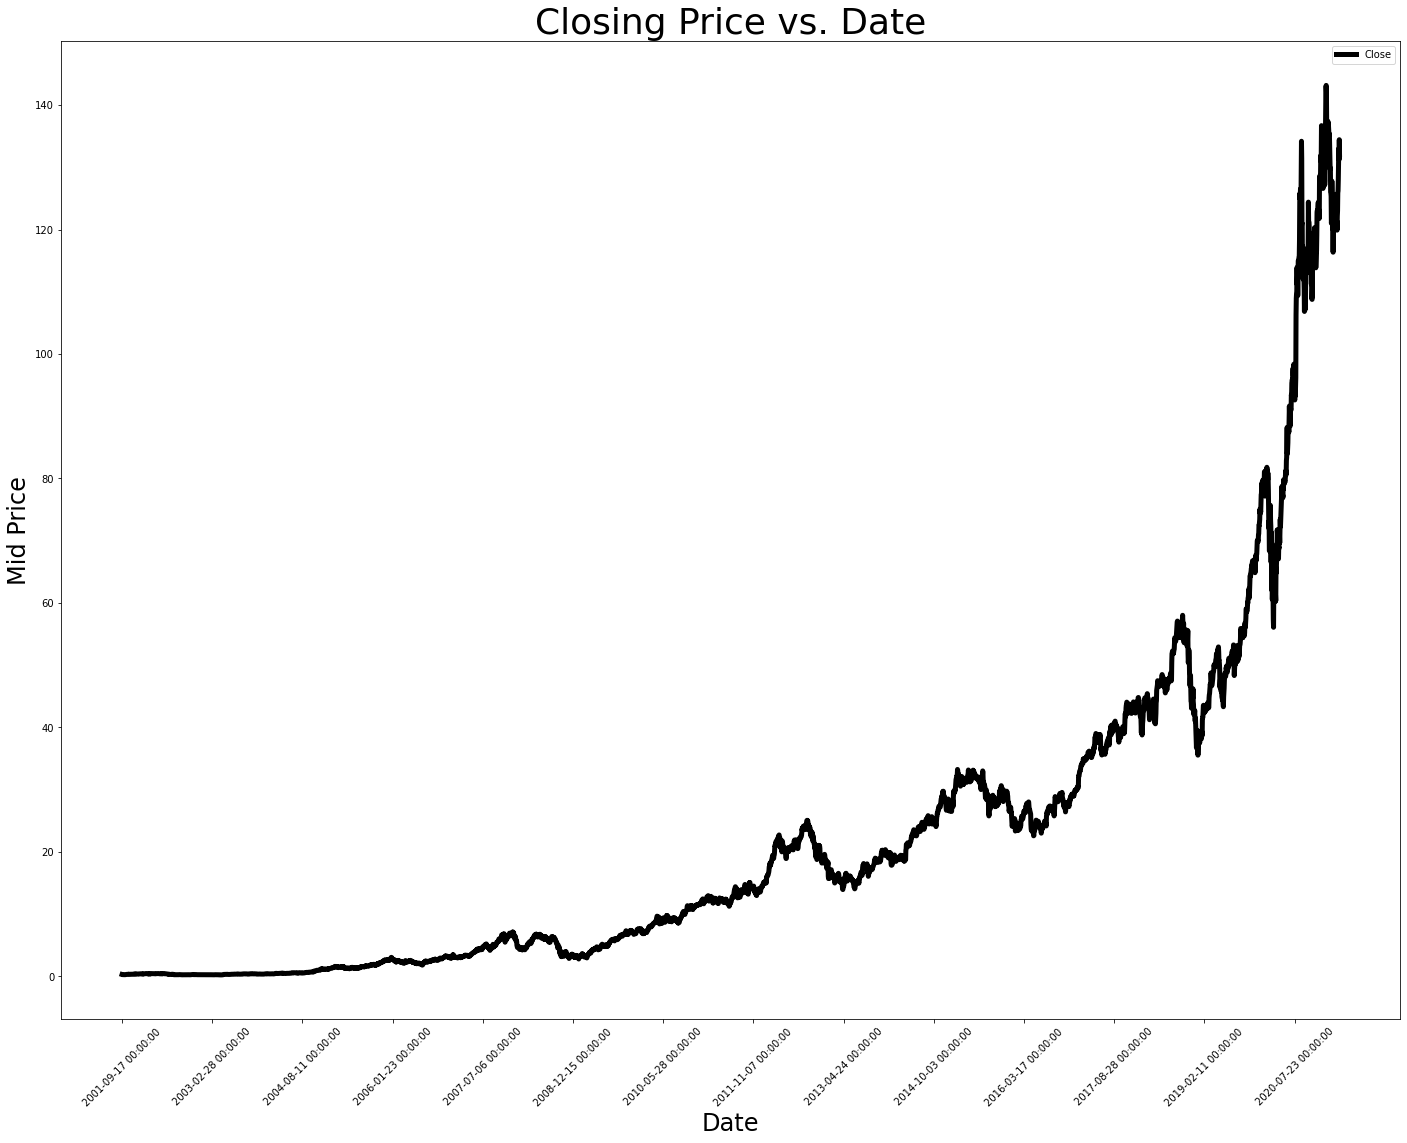

In [ ]:
fig = closing_data.get_line_plot( use_custom_df = True, df = closing_price_df, plot_features=False)
fig.show()

# Here's the next 5 day high/low prices overlaid over closing
Let's see the last 10% of data so we can see the different trends 

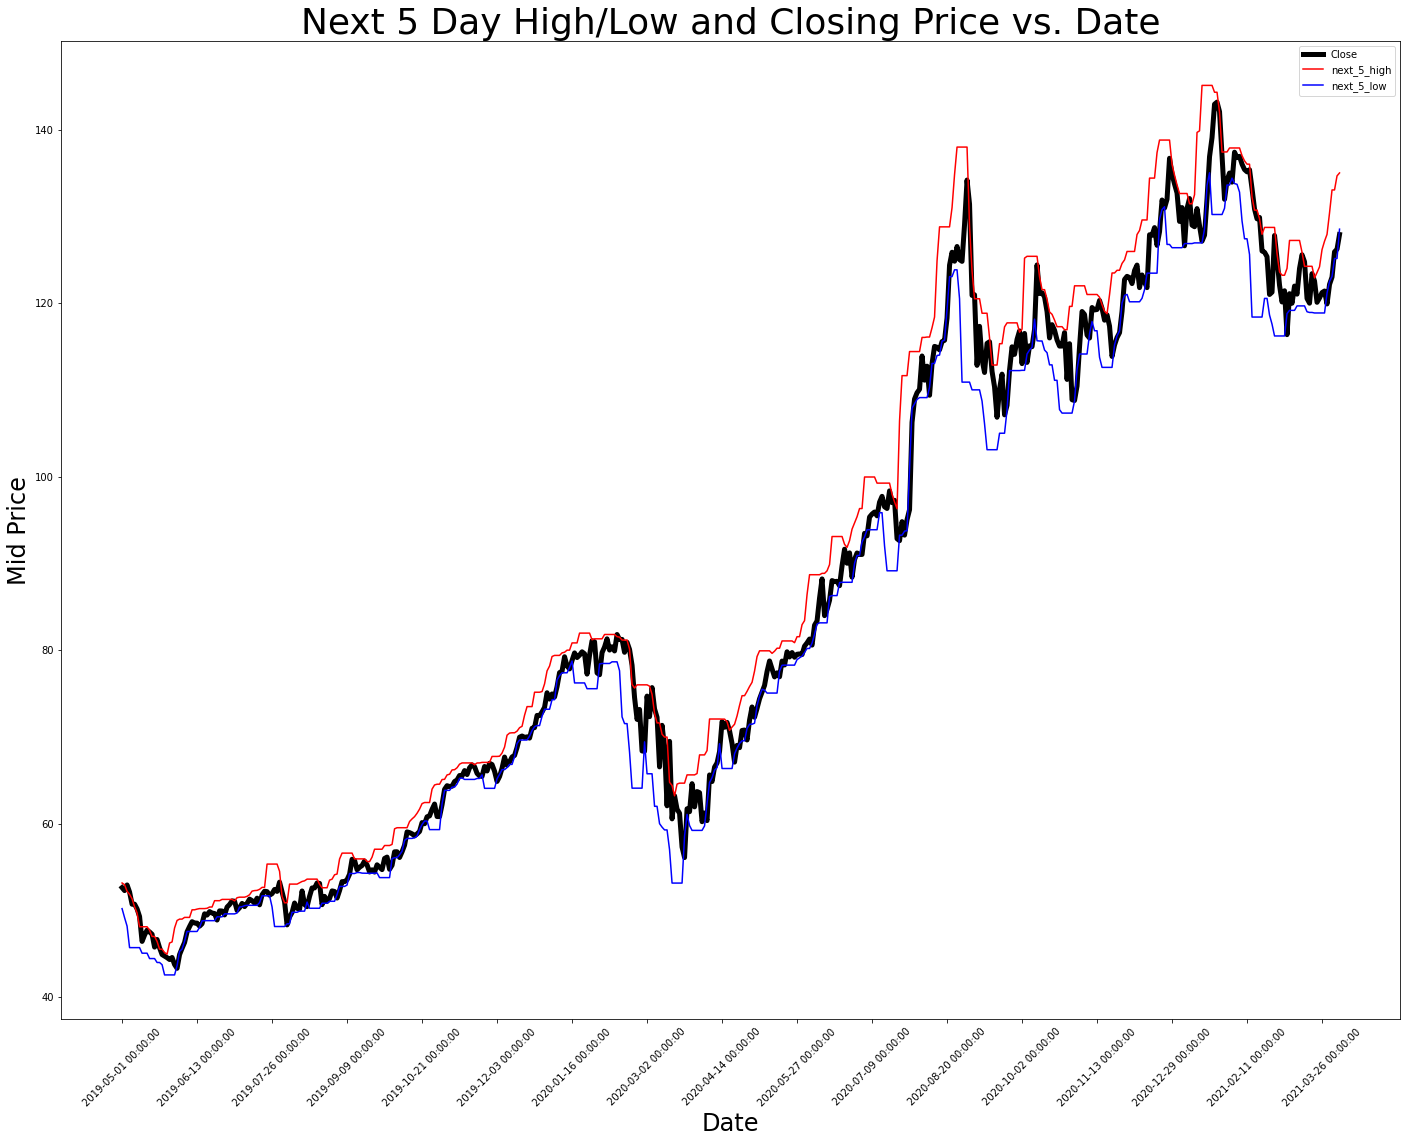

In [ ]:
dates = closing_price_df.index
start_date = dates[int(len(dates)*.9)]
end_date = dates[-1]
plot_df = five_day_high_df.join(five_day_low_df['next_5_low'])
fig = closing_data.get_next_high_low_plot(use_custom_df = True, df = plot_df.loc[start_date: end_date],  x_step=30)
fig.show()

# Technical Indicators 
Here we have plotted the 20, 50, and 100 weighted moving averages and volumed weighted average prices. Let's check out our indicators over the last 10 % of our data

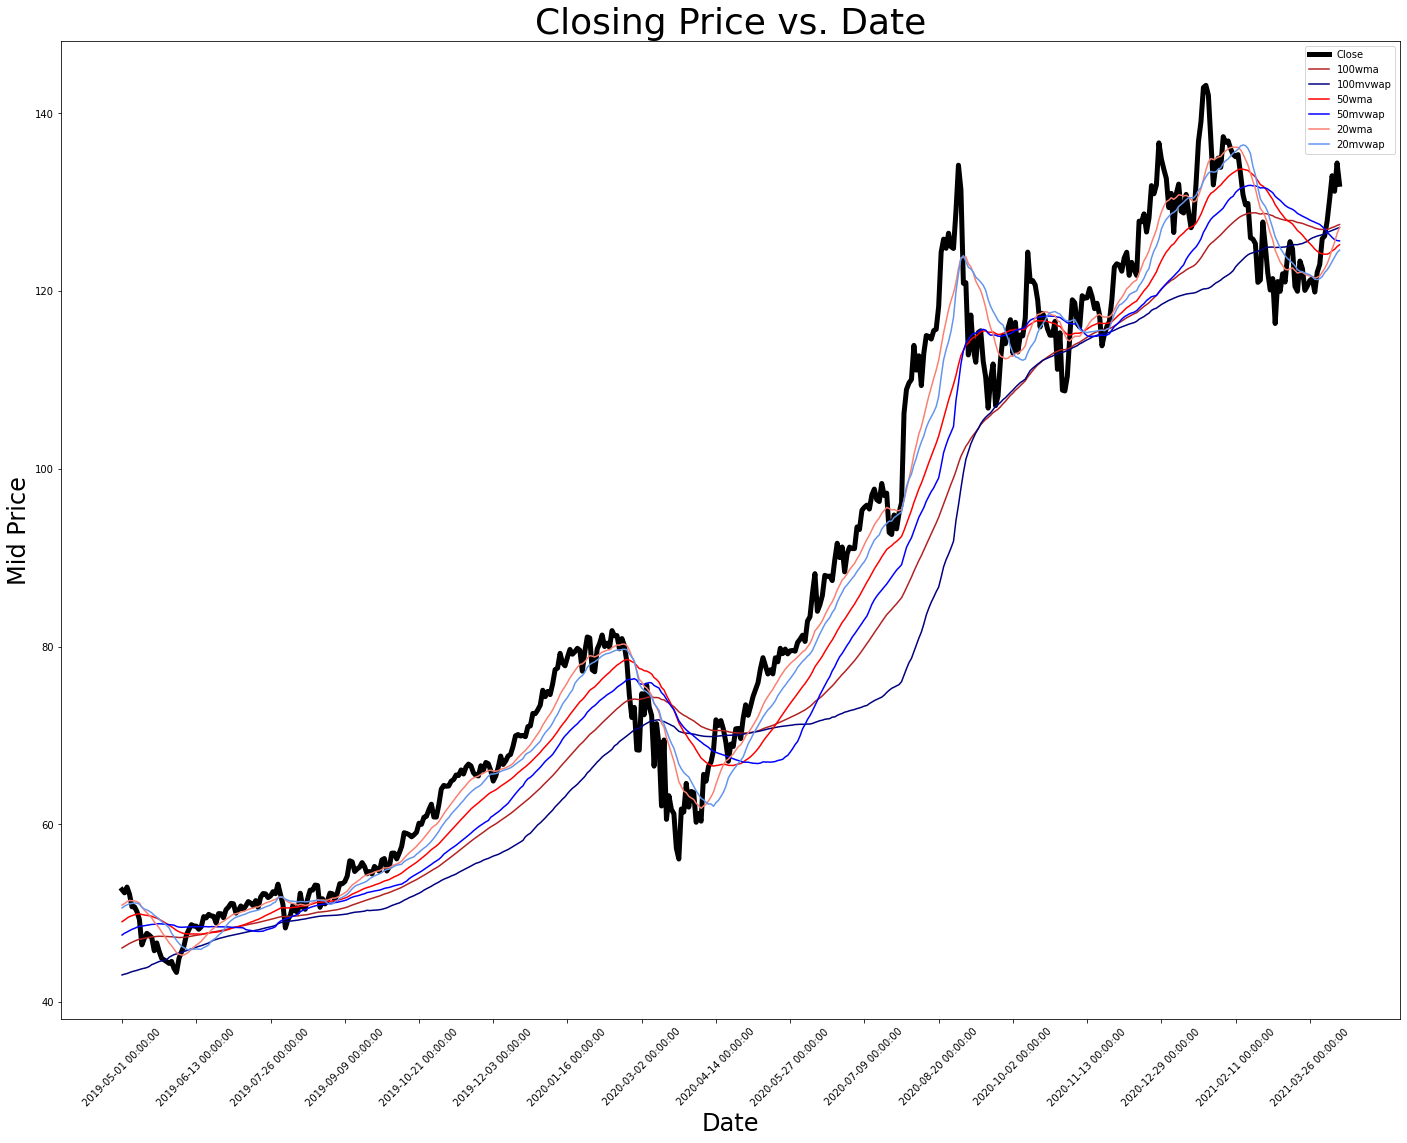

In [ ]:
fig = closing_data.get_line_plot( use_custom_df = True, df = closing_price_df.loc[start_date: end_date], plot_features=True, x_step=30)
fig.show()

# Define Model Names and Constants

In [ ]:
DIR_LOCATION = "./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/"
STOCK_NAME = STOCK_NAME
CLOSING_MODEL_NAME = f'{STOCK_NAME}_CLOSING_MODEL_2.h5'
FIVE_DAY_HIGH_MODEL_NAME = f'{STOCK_NAME}_FIVE_DAY_HIGH_MODEL.h5'
FIVE_DAY_LOW_MODEL_NAME = f'{STOCK_NAME}_FIVE_DAY_LOW_MODEL.h5'

# Define callbacks

In [ ]:
from google.colab import drive
import tensorflow as tf
drive.mount('/content/drive')

import datetime
import os


early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 10)

closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + CLOSING_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')

five_high_closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + FIVE_DAY_HIGH_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')

five_low_closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + FIVE_DAY_LOW_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = DIR_LOCATION,
                                                      histogram_freq=1,
                                                      write_graph=True,
                                                      write_images=False, 
                                                      update_freq='epoch')

closing_callbacks = [early_stop, closing_monitor, lr_schedule]

five_high_callbacks = [early_stop, five_high_closing_monitor, lr_schedule]

five_low_callbacks = [early_stop, five_low_closing_monitor, lr_schedule]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Model Architectures

In [ ]:
import tensorflow as tf
## TODO: Make sure this is best performing model 
def model(batch_size = 1, ishape = (100,5), lr = 1e-2):
  model_input = tf.keras.layers.Input(shape = ishape, batch_size = 1)
  l3 = tf.keras.layers.LSTM(units = 20, return_sequences = True, return_state = True, stateful=True)(model_input)  #Use False for only 1 dim return, True = full sequence of hidden states
  l4 = tf.keras.layers.LSTM(units = 20, return_sequences = False)(l3)  #Use False for only 1 dim return, True = full sequence of hidden states
  output = tf.keras.layers.Dense(1, activation = 'linear')(l4)
  model = tf.keras.Model(inputs = model_input, outputs = output)
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), 
                loss = tf.keras.losses.mean_squared_error) 
  return model


#ishape should be (timesteps, n_features)
BATCH_SIZE = 1
closing_model = model(batch_size = BATCH_SIZE, ishape=(100, closing_price_df.shape[1]))
# 15 features in these models (next high )
five_day_high_model = model(batch_size = BATCH_SIZE, ishape=(100, five_day_high_df.shape[1]))
five_day_low_model = model(batch_size = BATCH_SIZE, ishape=(100, five_day_low_df.shape[1]))


# Get custom time series data generators
Note: These generators were developed to provide windowed normalization. For the next 5 day high/low, the last 5 values are copied from the last valid data to avoid information from future steps being passed into training. (ie., 94th value is copied into 95-100th values for feautres generated with future data)

In [ ]:
# How about windowed normalization? We got you covered! Here we will use a min max scaler, but you can also use a standard scaler by passing min_max_scaler=False
train_scaled_closing_data, test_scaled_closing_data = StockData.get_timeseries_generators(df=closing_price_df,
                                                                            test_percentage = 0.3, 
                                                                            target_col='c',
                                                                            length=100,
                                                                            windowed_norm=True,
                                                                            min_max_scaler=True,
                                                                            batch_size=1, 
                                                                            target_idx = 3)


train_scaled_five_day_high, test_scaled_five_day_high = StockData.get_timeseries_generators(df=five_day_high_df,
                                                                            test_percentage = 0.3, 
                                                                            target_col='next_5_high',
                                                                            length=100,
                                                                            windowed_norm=True,
                                                                            min_max_scaler=True,
                                                                            batch_size=1, 
                                                                            mask = True, 
                                                                            mask_idx = 5, 
                                                                            target_idx = 3)

train_scaled_five_day_low, test_scaled_five_day_low = StockData.get_timeseries_generators(df=five_day_low_df,
                                                                            test_percentage = 0.3, 
                                                                            target_col='next_5_low',   
                                                                            length=100,
                                                                            windowed_norm=True,
                                                                            min_max_scaler=True,
                                                                            batch_size=1, 
                                                                            mask = True, 
                                                                            mask_idx = 5, 
                                                                            target_idx = 3 )

# Prepare Trainers



In [ ]:
# Arnold schwarzenegger likes to train
arnold_closing = Trainer(None, closing_model, CLOSING_MODEL_NAME, train_scaled_closing_data, test_scaled_closing_data)
arnold_next_high = Trainer(None, five_day_high_model, FIVE_DAY_HIGH_MODEL_NAME, train_scaled_five_day_high, test_scaled_five_day_high)
arnold_next_low = Trainer(None, five_day_low_model, FIVE_DAY_LOW_MODEL_NAME, train_scaled_five_day_low, test_scaled_five_day_low)

# Training Model - Tomorrow's Closing Price

In [ ]:
arnold_closing.train_model(100, True, callbacks=closing_callbacks)

TRAINING
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3349/3349 [==============================] - 125s 37ms/step - loss: 0.1545

Epoch 00001: loss improved from inf to 0.11812, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/AAPL_CLOSING_MODEL.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3349/3349 [==============================] - 119s 35ms/step - loss: 0.0752

Epoch 00002: loss improved from 0.11812 to 0.06912, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/AAPL_CLOSING_MODEL.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3349/3349 [==============================] - 120s 36ms/step - loss: 0.0662

Epoch 00003: loss improved from 0.06912 to 0.05929, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/AAPL_CLOSING_MODEL.h5
Epoch 4/100

Epoch 0000

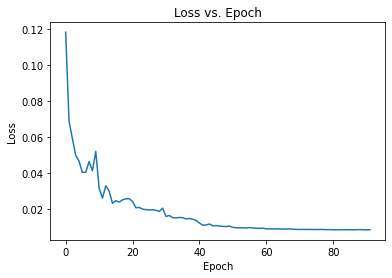

In [ ]:
fig = arnold_closing.graph_loss()

# Training Model - Next 5 Day High Price

In [ ]:
arnold_next_high.train_model(100, True, callbacks=five_high_callbacks)

TRAINING
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3346/3346 [==============================] - 128s 37ms/step - loss: 0.1594

Epoch 00001: loss improved from inf to 0.12661, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/AAPL_FIVE_DAY_HIGH_MODEL.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3346/3346 [==============================] - 118s 35ms/step - loss: 0.0956

Epoch 00002: loss improved from 0.12661 to 0.08787, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/AAPL_FIVE_DAY_HIGH_MODEL.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3346/3346 [==============================] - 120s 36ms/step - loss: 0.0793

Epoch 00003: loss improved from 0.08787 to 0.07791, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/AAPL_FIVE_DAY_HIGH_MODEL.h5
Epoch

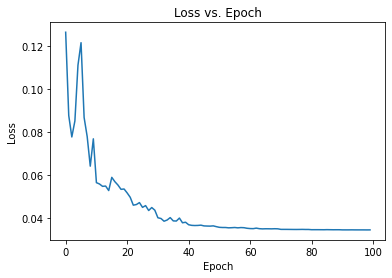

In [ ]:
fig = arnold_next_high.graph_loss()

# Training Model - Next 5 Day Low Price

In [ ]:
arnold_next_low.train_model(100, True, callbacks=five_low_callbacks)

TRAINING
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3346/3346 [==============================] - 126s 38ms/step - loss: 0.1307

Epoch 00001: loss improved from inf to 0.13066, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/AAPL_FIVE_DAY_LOW_MODEL.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3346/3346 [==============================] - 120s 36ms/step - loss: 0.0763

Epoch 00002: loss improved from 0.13066 to 0.07627, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/AAPL_FIVE_DAY_LOW_MODEL.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3346/3346 [==============================] - 120s 36ms/step - loss: 0.0726

Epoch 00003: loss improved from 0.07627 to 0.07259, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/AAPL_FIVE_DAY_LOW_MODEL.h5
Epoch 4/

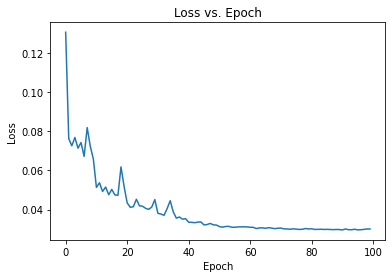

In [ ]:
fig = arnold_next_low.graph_loss()

# Results - Tomorrow's Closing Price

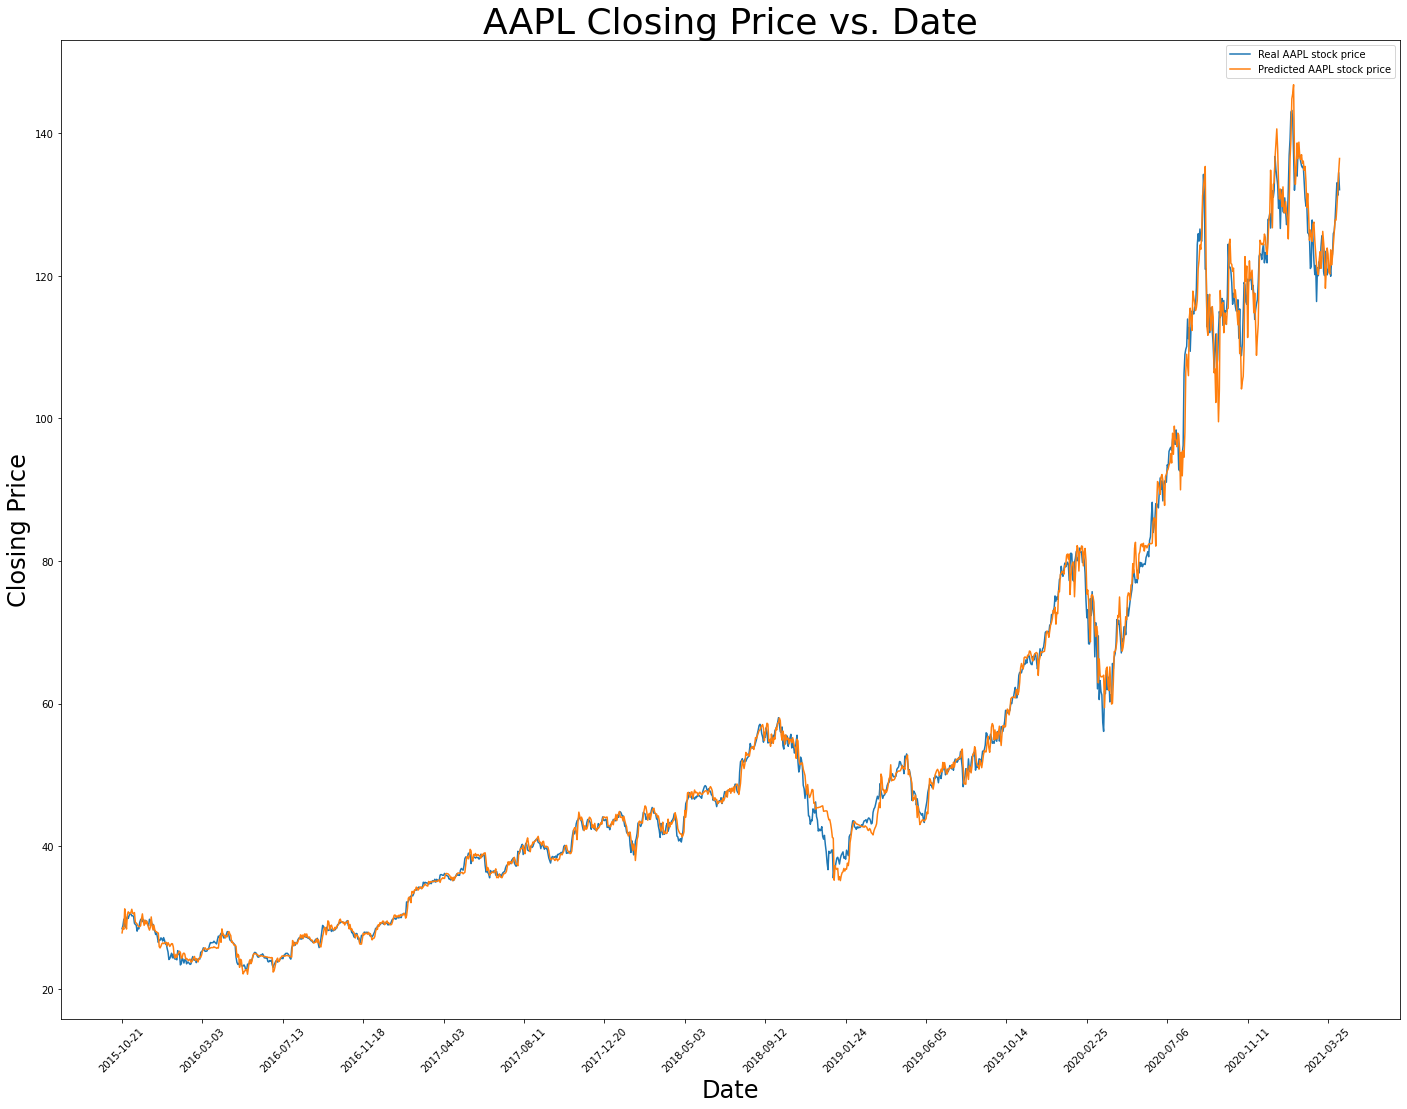

In [ ]:
from deeptendies.result_plots import ModelResultPlots
#ATTEMPT 2
# closing_model.load_weights(DIR_LOCATION + CLOSING_MODEL_NAME)
# arnold_closing.model = closing_model
def get_results(df, train_data_gen, model, title = "Closing Price vs. Date", predicted_value_name = "stock price"): 
  train_idx, test_idx= StockData.get_train_test_split(df)
  days = [str(x).split("T")[0] for x in df.index[train_idx+train_data_gen.length:].values]
  predictions = model.get_predictions()
  y_true = predictions['actual']
  y_predicted = predictions['predicted']
  fig = ModelResultPlots.plot_predicted_vs_original_price(y_true, y_predicted, STOCK_NAME, days, x_step=91, title=title, predicted_value_name = predicted_value_name)
  return fig, y_true, y_predicted


fig, y_true, y_predicted = get_results(closing_price_df, train_scaled_closing_data, arnold_closing)
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{CLOSING_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()

AAPL_CLOSING_MODEL_2.h5 achieved the folowing results:
Mean squared error:		 3.8796187166025558
Root mean squared error:	 1.9696747743225418
Mean absolute error:		 1.1810251145504627
Mean absolute percentage error:	 0.020293688445249154
Mean percentage error:		 -0.0022601982733228606
Mean directional accuracy:	 0.4985486211901306


# Results - Next 5 Day High Price

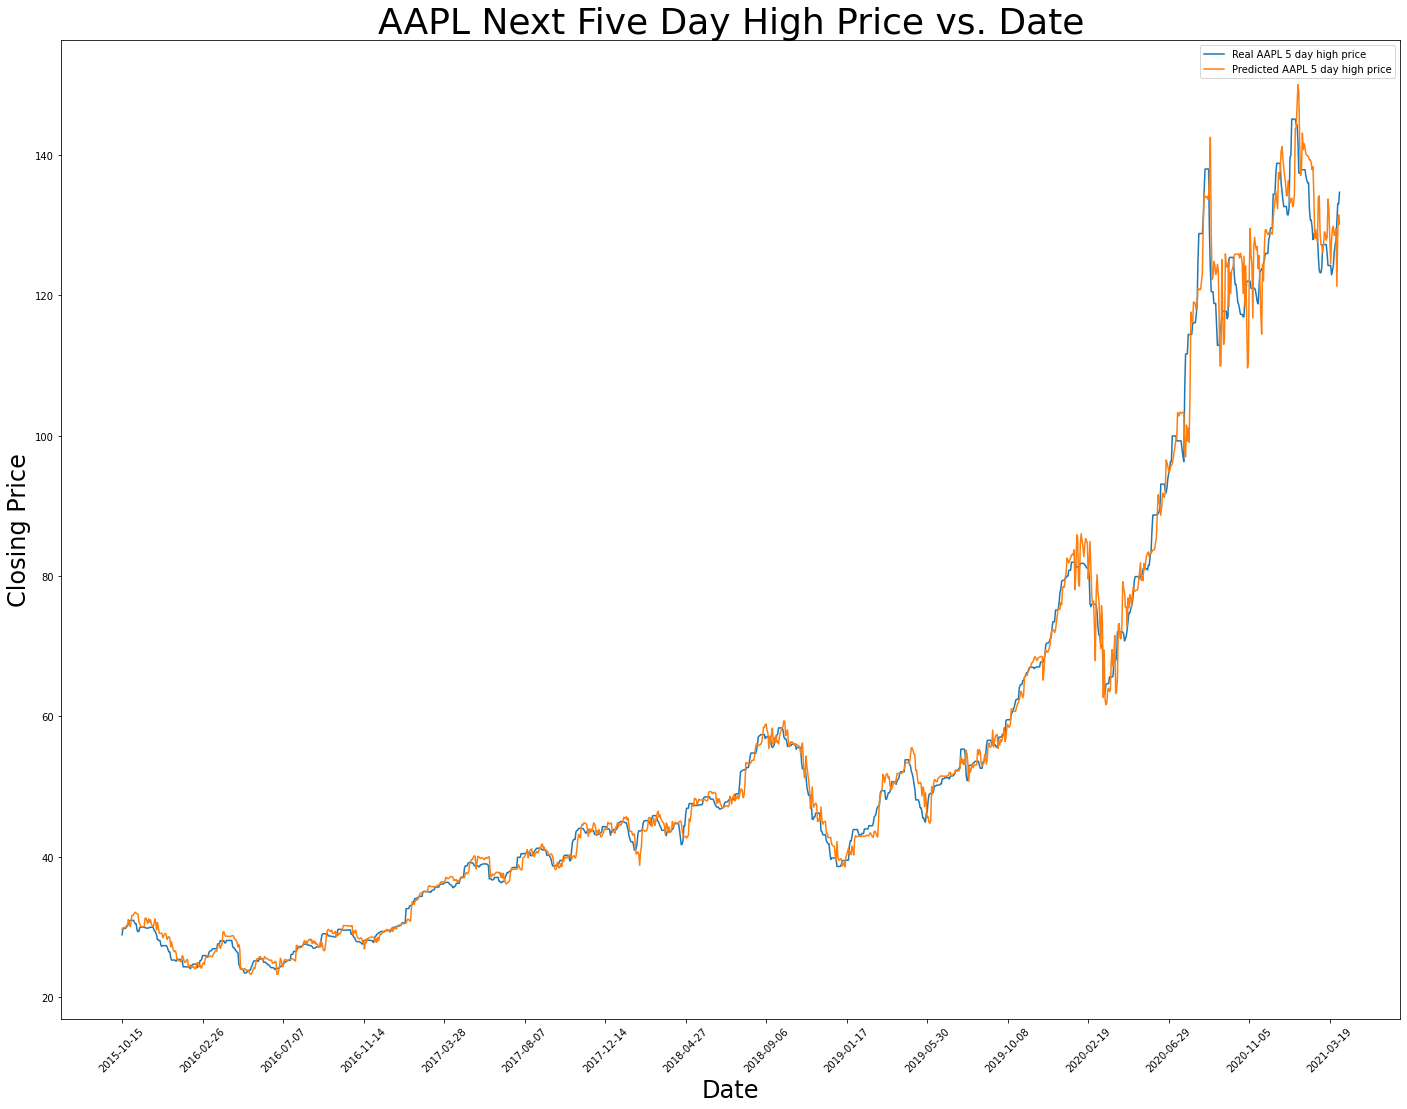

In [ ]:
fig, y_true, y_predicted = get_results(five_day_high_df, train_scaled_five_day_high, arnold_next_high, title = "Next Five Day High Price vs. Date", predicted_value_name = "5 day high price")
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{FIVE_DAY_HIGH_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()

AAPL_FIVE_DAY_HIGH_MODEL.h5 achieved the folowing results:
Mean squared error:		 6.8976479771186865
Root mean squared error:	 2.626337369249938
Mean absolute error:		 1.591399342185514
Mean absolute percentage error:	 0.025877321005336164
Mean percentage error:		 -0.005564366648872894
Mean directional accuracy:	 0.2768895348837209


# Results - Next 5 Day Low Price

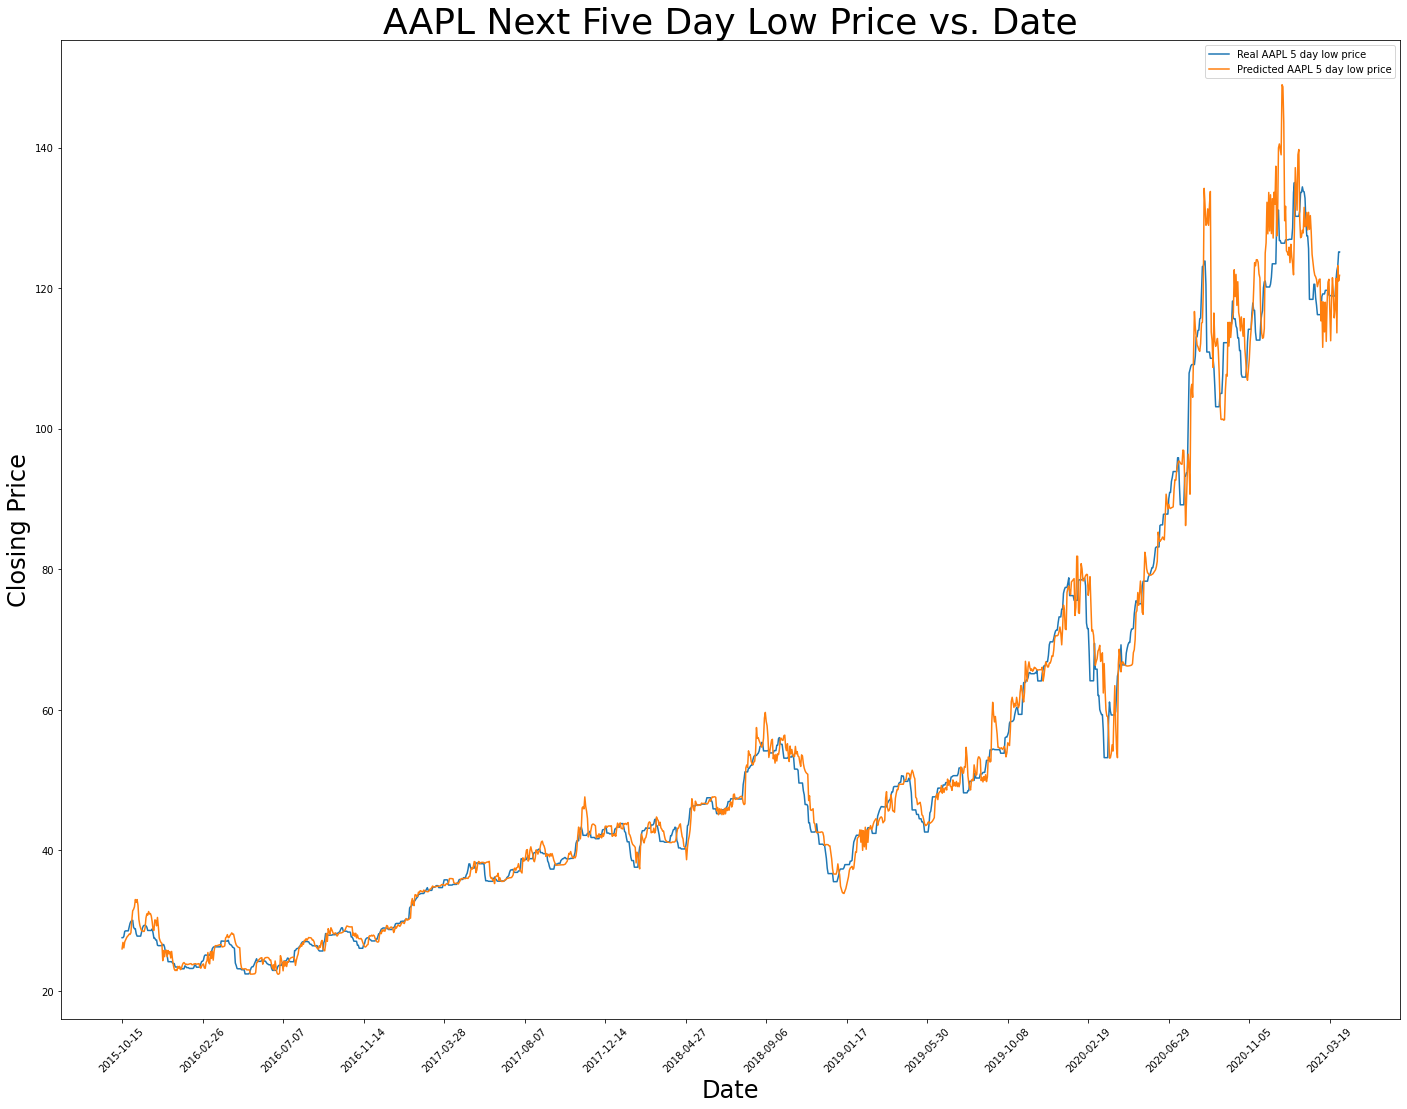

In [ ]:
five_day_low_model.load_weights(DIR_LOCATION + FIVE_DAY_LOW_MODEL_NAME)
arnold_next_low.model = five_day_low_model
fig, y_true, y_predicted = get_results(five_day_low_df, train_scaled_five_day_low, arnold_next_low, title = "Next Five Day Low Price vs. Date", predicted_value_name = "5 day low price")
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{FIVE_DAY_LOW_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()

AAPL_FIVE_DAY_LOW_MODEL.h5 achieved the folowing results:
Mean squared error:		 11.26214228210215
Root mean squared error:	 3.355911542651586
Mean absolute error:		 1.962108396338724
Mean absolute percentage error:	 0.03374939486474929
Mean percentage error:		 -0.009756449879099299
Mean directional accuracy:	 0.2747093023255814


In [ ]:
DIR_LOCATION = "./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/"
STOCK_NAME = STOCK_NAME
CLOSING_MODEL_NAME = f'{STOCK_NAME}_CLOSING_MODEL_V2.h5'

In [ ]:
from google.colab import drive
import tensorflow as tf
drive.mount('/content/drive')

import datetime
import os


early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 10)

closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + CLOSING_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = DIR_LOCATION,
                                                      histogram_freq=1,
                                                      write_graph=True,
                                                      write_images=False, 
                                                      update_freq='epoch')

closing_callbacks = [early_stop, closing_monitor, lr_schedule]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
CLOSING_MODEL_NAME

'AAPL_CLOSING_MODEL_V2.h5'

In [ ]:
import tensorflow as tf
## TODO: Make sure this is best performing model 
def model(batch_size = 1, ishape = (100,5), lr = 1e-2):
  model_input = tf.keras.layers.Input(shape = ishape, batch_size = 1)
  t = tf.keras.layers.LSTM(units = 100, return_sequences = False, return_state = False, stateful=True)(model_input) #Use False for only 1 dim return, True = full sequence of hidden states
  output = tf.keras.layers.Dense(1, activation = 'linear')(t)
  model = tf.keras.Model(inputs = model_input, outputs = output)
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), 
                loss = tf.keras.losses.mean_squared_error) 
  return model


#ishape should be (timesteps, n_features)
BATCH_SIZE = 1
closing_model = model(batch_size = BATCH_SIZE, ishape=(100, closing_price_df.shape[1]))


In [ ]:
arnold_closing = Trainer(None, closing_model, CLOSING_MODEL_NAME, train_scaled_closing_data, test_scaled_closing_data)

In [ ]:
arnold_closing.train_model(100, True, callbacks=closing_callbacks)

TRAINING
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3349/3349 [==============================] - 84s 25ms/step - loss: 0.1826

Epoch 00001: loss improved from inf to 0.16868, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/AAPL_CLOSING_MODEL_V2.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3349/3349 [==============================] - 83s 25ms/step - loss: 0.1154

Epoch 00002: loss improved from 0.16868 to 0.08450, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/AAPL_CLOSING_MODEL_V2.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3349/3349 [==============================] - 82s 25ms/step - loss: 0.0783

Epoch 00003: loss improved from 0.08450 to 0.07225, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/AAPL_CLOSING_MODEL_V2.h5
Epoch 4/100

Epoc

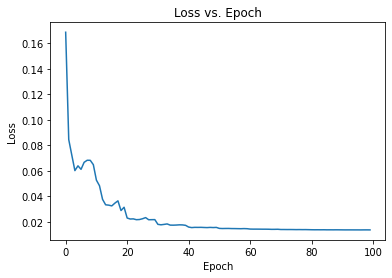

In [ ]:
fig = arnold_closing.graph_loss()

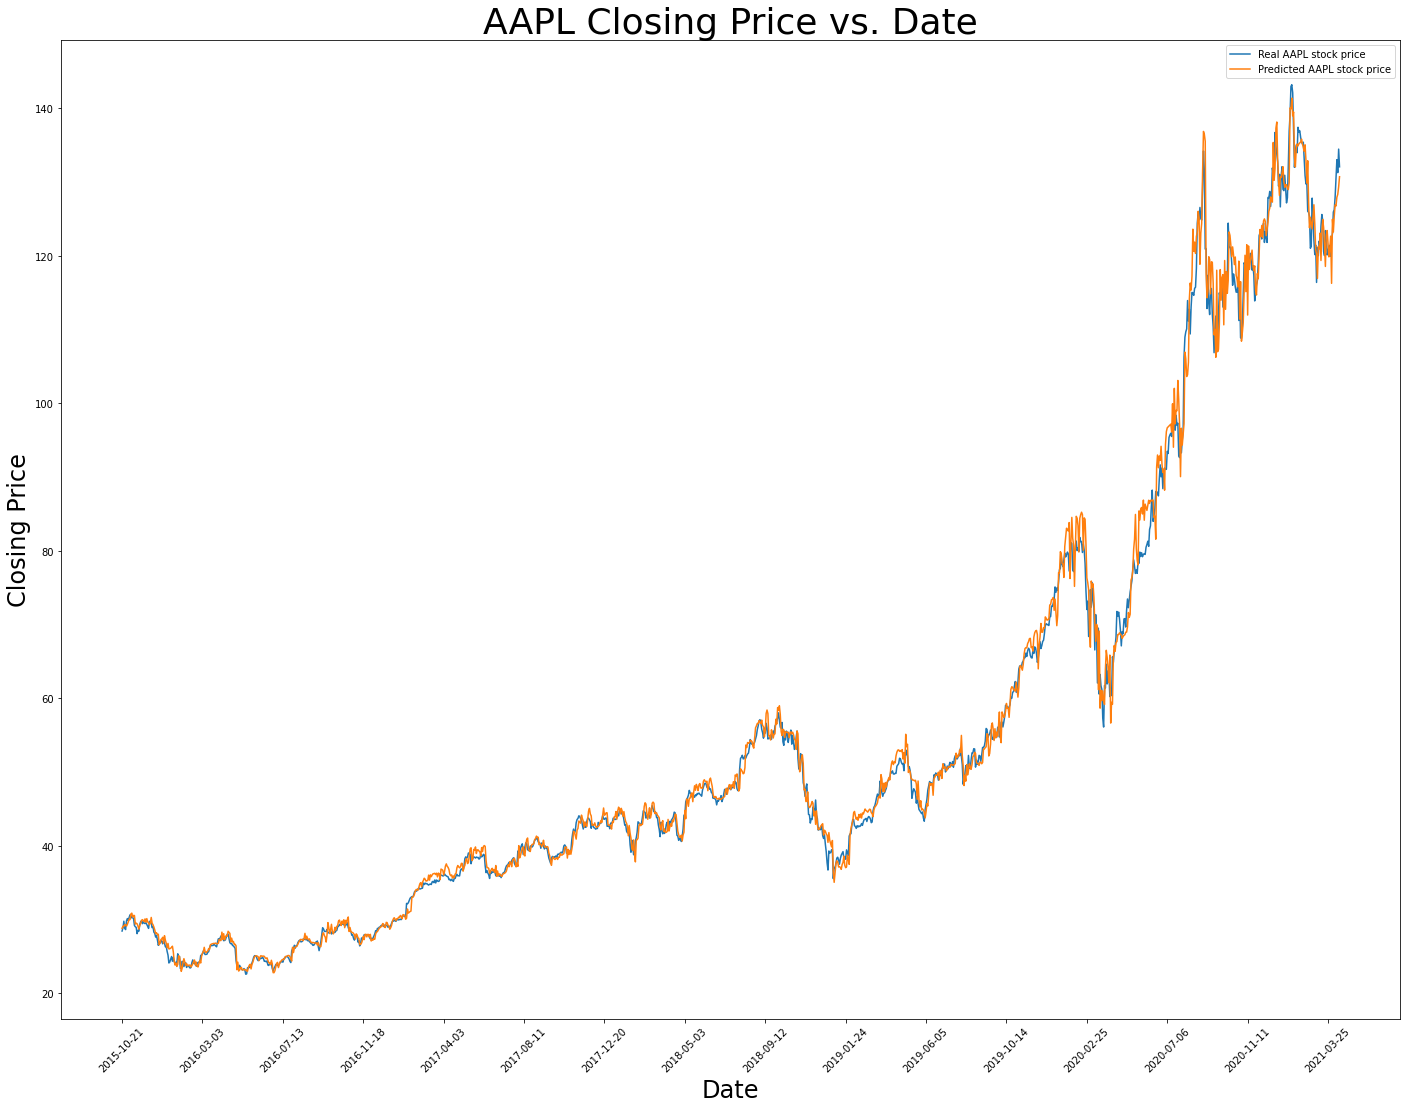

In [ ]:
from deeptendies.result_plots import ModelResultPlots
#ATTEMPT 2
# closing_model.load_weights(DIR_LOCATION + CLOSING_MODEL_NAME)
# arnold_closing.model = closing_model
def get_results(df, train_data_gen, model, title = "Closing Price vs. Date", predicted_value_name = "stock price"): 
  train_idx, test_idx= StockData.get_train_test_split(df)
  days = [str(x).split("T")[0] for x in df.index[train_idx+train_data_gen.length:].values]
  predictions = model.get_predictions()
  y_true = predictions['actual']
  y_predicted = predictions['predicted']
  fig = ModelResultPlots.plot_predicted_vs_original_price(y_true, y_predicted, STOCK_NAME, days, x_step=91, title=title, predicted_value_name = predicted_value_name)
  return fig, y_true, y_predicted


fig, y_true, y_predicted = get_results(closing_price_df, train_scaled_closing_data, arnold_closing)
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{CLOSING_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()

AAPL_CLOSING_MODEL_V2.h5 achieved the folowing results:
Mean squared error:		 4.030627931304528
Root mean squared error:	 2.0076423813280413
Mean absolute error:		 1.25554408791966
Mean absolute percentage error:	 0.02106560197088881
Mean percentage error:		 -0.006630404642674261
Mean directional accuracy:	 0.5174165457184325
